In [1]:
import sys
print(sys.executable)
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [2]:
# Importaciones necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Agregar la ruta de los scripts al sistema
sys.path.append(os.path.abspath("../scripts"))

# Importar el modelo y las clases de datasets
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:
# Configuración general
DATA_DIR = "../data/datasets"  # Carpeta donde están los datasets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 1
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FEATURE_DIM = 128
POOLING_TYPE = "max"  # Opciones: 'attention', 'mean', 'max'
FEATURE_DIM = 128 

# Parámetros específicos de los datasets
D = 2  # Dimensionalidad de los datos
NUM_BAGS = 100  # Número de bolsas
B = 5  # Número de instancias negativas por bolsa
POS_CLASS_PROB = 0.5  # Probabilidad de que una bolsa sea positiva
SEED = 42  # Semilla para reproducibilidad

In [9]:
# Crear instancias de los datasets
sc_dataset = SCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

mc_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

false_freq_dataset = FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

# Crear dataloaders
sc_loader = DataLoader(sc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=sc_dataset.collate_fn)
mc_loader = DataLoader(mc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=mc_dataset.collate_fn)
false_freq_loader = DataLoader(false_freq_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
def train_model(loader, model, criterion, optimizer, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            bag_data, bag_label = bag_data.to(DEVICE), bag_label.float().to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            optimizer.zero_grad()
            predictions, _ = model(bag_data, mask=mask)
            loss = criterion(predictions.squeeze(), bag_label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [ ]:
def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for bag_data, bag_label, _, _, mask in loader:
            bag_data = bag_data.to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None
            output, _ = model(bag_data, mask=mask)
            preds = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(bag_label.cpu().numpy())
    
    # Calcular métricas
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()

# Ejemplo para SCStandard
print("=== Entrenando en SCStandard Dataset ===")
model = MILModel(input_feature_dim=D, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(sc_loader, model, criterion, optimizer)

print("=== Evaluando en SCStandard Dataset ===")
evaluate_model(sc_loader, model)

# Reiniciar para MCStandard
print("=== Entrenando en MCStandard Dataset ===")
model = MILModel(input_feature_dim=D, feature_dim=FEATURE_DIM, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(mc_loader, model, criterion, optimizer)

print("=== Evaluando en MCStandard Dataset ===")
evaluate_model(mc_loader, model)

# Reiniciar para False Frequency
print("=== Entrenando en False Frequency Dataset ===")
model = MILModel(input_feature_dim=D, feature_dim=FEATURE_DIM, pooling_type=POOLING_TYPE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_model(false_freq_loader, model, criterion, optimizer)


print("=== Evaluando en False Frequency Dataset ===")
evaluate_model(false_freq_loader, model)

=== Entrenando en SCStandard Dataset ===


ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([]))

probar de nuevo

Label de la bolsa: 0
Etiquetas de instancia: [-1.  0.  0.  0.  0.  0.]


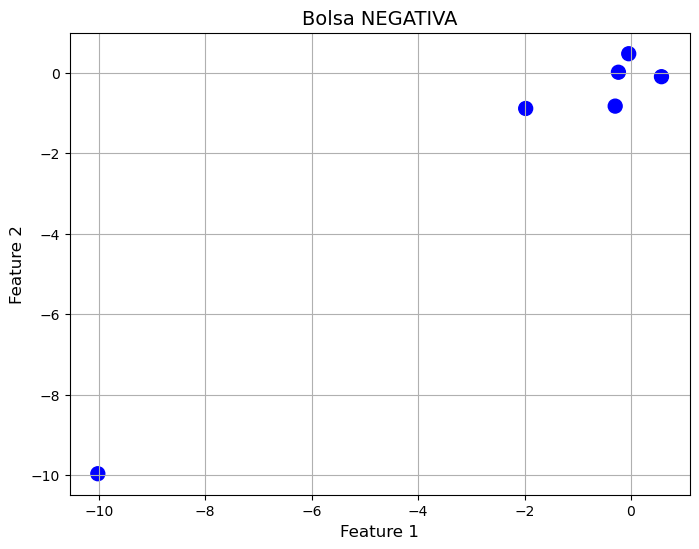

✅ Suposición MIL validada correctamente.


In [32]:

# Configuración
D = 2          # Dimensionalidad de las instancias (2D para visualización)
NUM_BAGS = 100  # Número de bolsas
B = 5          # Instancias negativas por bolsa
BATCH_SIZE = 1

# Crear dataset
sc_dataset = SCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=0.5,
    train=True,
    seed=42
)

# Crear DataLoader
sc_loader = DataLoader(
    sc_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=sc_dataset.collate_fn
)

# Visualizar una bolsa
def visualize_bag(bag_data, bag_label, instance_labels):
    plt.figure(figsize=(8, 6))
    colors = ['red' if label == 1 else 'blue' for label in instance_labels]
    plt.scatter(bag_data[:, 0], bag_data[:, 1], c=colors, s=100)
    plt.title(f"Bolsa {'POSITIVA' if bag_label else 'NEGATIVA'}", fontsize=14)
    plt.xlabel("Feature 1", fontsize=12)
    plt.ylabel("Feature 2", fontsize=12)
    plt.grid(True)
    plt.show()

# Ejemplo de visualización
for bag_data, bag_label, instance_labels, adj_mat, mask in sc_loader:
    print("Label de la bolsa:", bag_label[0].item())
    print("Etiquetas de instancia:", instance_labels[0].numpy())
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

# Verificar suposición MIL
def check_mil_assumption(dataset):
    for bag in dataset.bags_list:
        X = bag['X']
        Y = bag['Y']
        y_inst = bag['y_inst']
        
        # Bolsas positivas deben tener al menos una instancia positiva
        if Y == 1:
            assert (y_inst == 1).any(), f"Bolsa positiva sin instancias positivas: {bag}"
        
        # Bolsas negativas no deben tener instancias positivas
        if Y == 0:
            assert (y_inst[y_inst != -1] == 0).all(), f"Bolsa negativa con instancias positivas: {bag}"
    
    print("✅ Suposición MIL validada correctamente.")

check_mil_assumption(sc_dataset)